In [ ]:
!pip install networkx
!pip install python-louvain
!pip install torch_geometric 


In [17]:
import numpy as np                                     # Numerical Python
import pandas as pd                                    # Pandas
import matplotlib.pyplot as plt                        # Default python plotting library.
from tqdm.autonotebook import tqdm  
import random as rd

import torch
import torch.nn as nn
import torch.optim as optim

import networkx as nx #load karate dataset
import community as community_louvain


Modularity: 0.44490358126721763


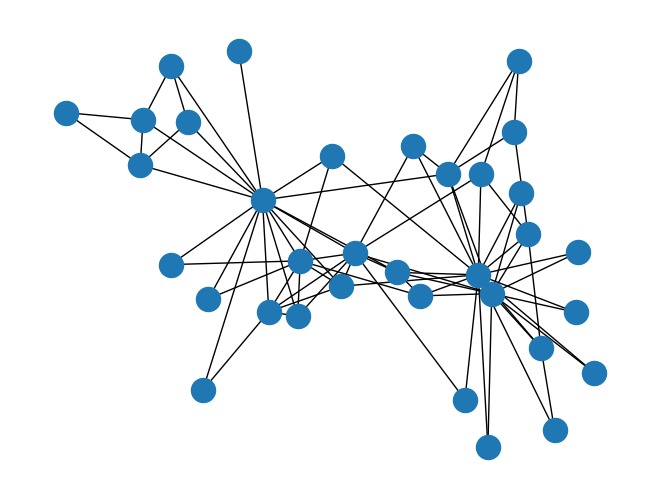

In [18]:


# Load the Karate Club graph
G = nx.karate_club_graph()

partition = community_louvain.best_partition(G)

# Print modularity score
modularity = community_louvain.modularity(partition, G)
print(f"Modularity: {modularity}")

# Assign colors to nodes based on their community
colors = [partition[node] for node in G.nodes()]

# Draw the graph
nx.draw(G)
plt.show()



# Graph embedding


![Screenshot 2025-01-21 111821.png](<attachment:Screenshot 2025-01-21 111821.png>)
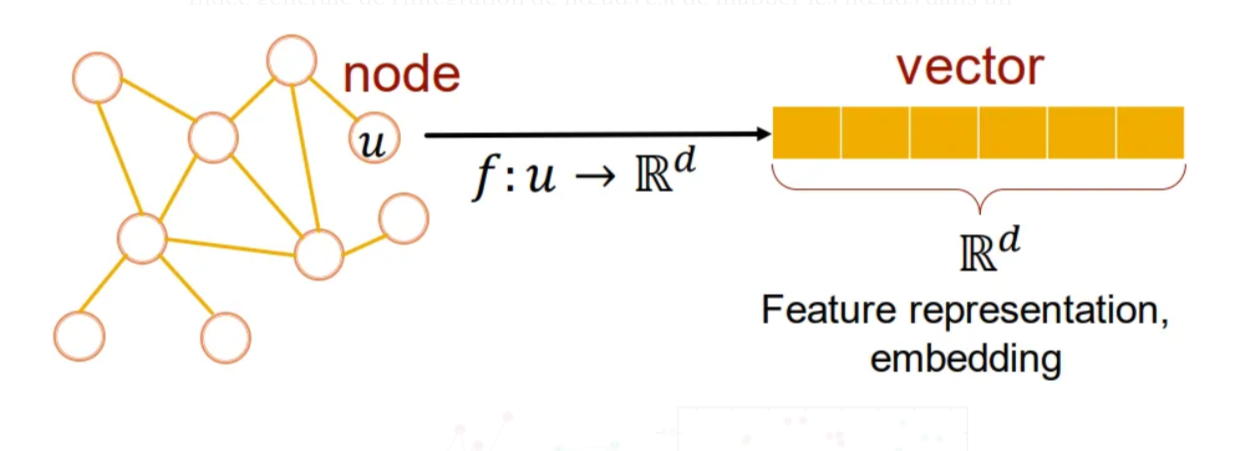

The general idea of node embedding is to map nodes into an embedding space that has less dimension than the number of nodes in the graph. In embedding space, it retains some of the same properties as in the graph. The similarity of a pair of nodes in the graph corresponds to their similarity in the embedding space. For example, if two nodes are connected on a graph, they will be close together in the embedding space.

![Screenshot 2025-01-21 111835.png](<attachment:Screenshot 2025-01-21 111835.png>)
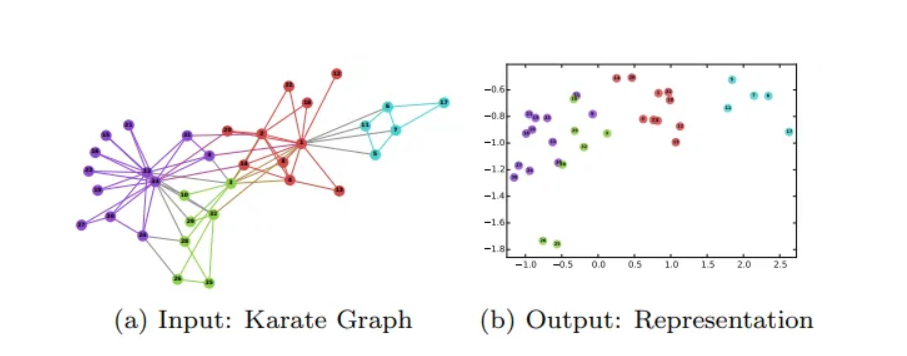

# DeepWalk

For the deepwalk implementation we need a :
- random walk function
- skip gram function

Then the overall deepwalk algorithm

![Screenshot 2025-01-21 111852.png](<attachment:Screenshot 2025-01-21 111852.png>)
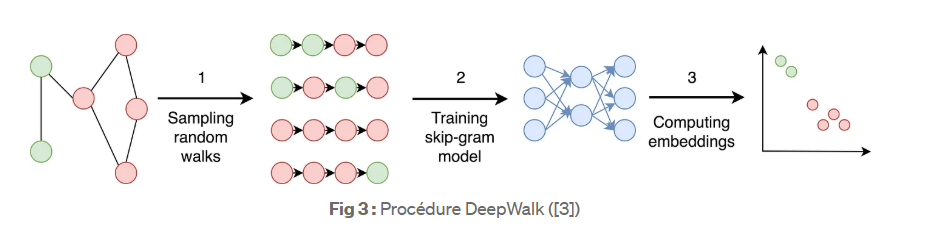

# Demonstration Skip-Gram with Negative Sampling (SGNS)


**SGNS as Implicit Matrix Factorization**

![Screenshot 2025-01-21 150822.png](<attachment:Screenshot 2025-01-21 150822.png>)

![Screenshot 2025-01-21 150901.png](<attachment:Screenshot 2025-01-21 150901.png>)
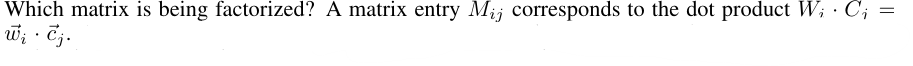

***Following the work by Levy and Goldberg , SGNS is implicitly factorizing***

![Screenshot 2025-01-21 145749.png](<attachment:Screenshot 2025-01-21 145749.png>) (1)

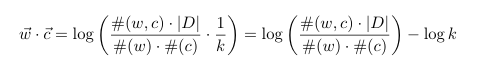

**Proof**

![Screenshot 2025-01-21 151141.png](<attachment:Screenshot 2025-01-21 151141.png>) (2)
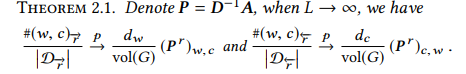

![Screenshot 2025-01-21 151433.png](<attachment:Screenshot 2025-01-21 151433.png>) (3)
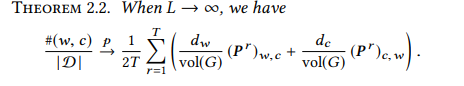

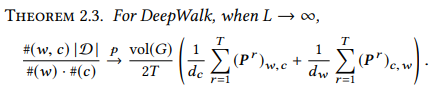 (4)

**Finally,**

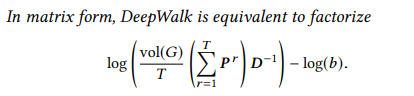

In [19]:
# random walk

def random_walk(adj_matrix,start_node,length):
    #we will authorize revisit
    nodes_visited,path=[start_node],[start_node]
    
    #while loop so we force to be of length even if we revisit a node
    while len(nodes_visited)<length:
        actual_node=path[-1]
        neighbors_index=np.where(adj_matrix[actual_node] == 1)[0]
        actual_node=np.random.choice(neighbors_index)
        
        path.append(actual_node) #we want to keep the path to visualize better our path and understand our random walk 
        
        #only append a node to the visited node if not visited before
        if actual_node not in nodes_visited:
            nodes_visited.append(actual_node)
    return nodes_visited,path
        
# Visualization of our random walk on a given graph        
def draw_random_walk(G, path):
    pos = nx.spring_layout(G)  # Compute graph layout
    plt.figure(figsize=(10, 8))
    
    # Draw all nodes and edges
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500)
    
    # Highlight the nodes in the path
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color="orange", node_size=600)
    
    # Highlight the edges in the random walk
    edges_in_walk = [(path[i], path[i+1]) for i in range(len(path) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=edges_in_walk, edge_color="red", width=2.5)
    
    plt.title(f"Random Walk on (Start Node: {path[0]})")
    plt.show()

    

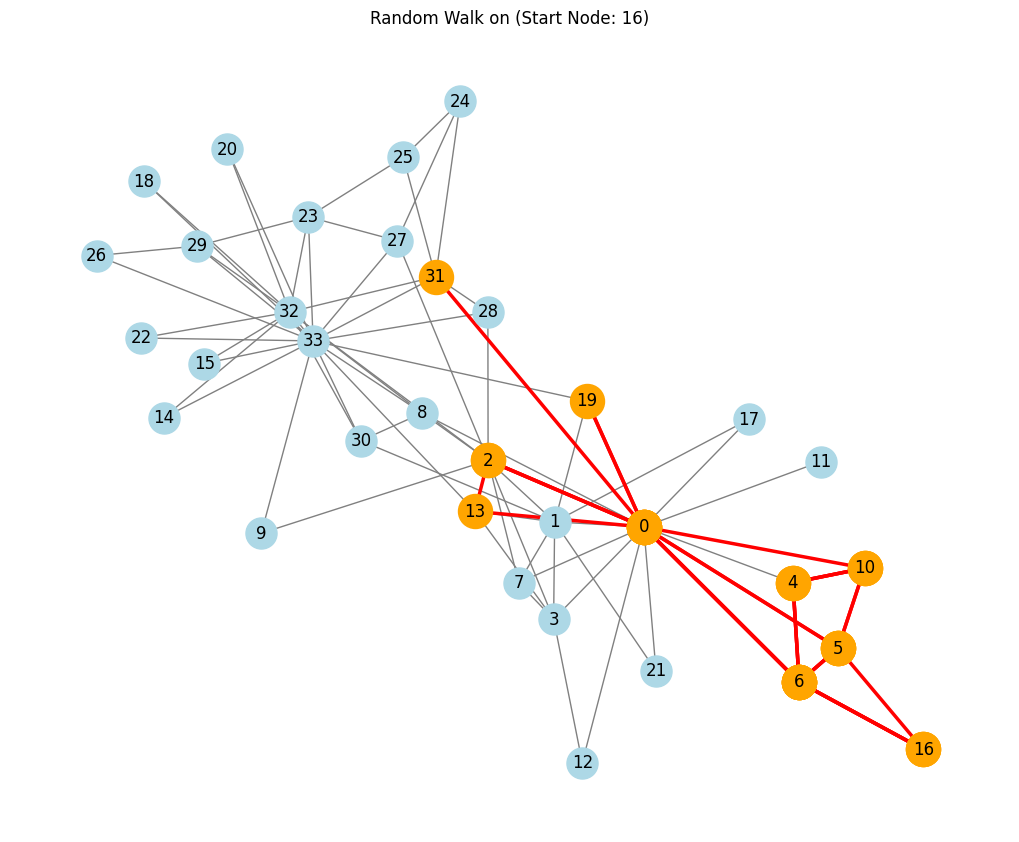

[16,
 6,
 5,
 16,
 6,
 0,
 2,
 0,
 19,
 0,
 5,
 6,
 5,
 10,
 0,
 5,
 10,
 4,
 10,
 4,
 6,
 16,
 6,
 4,
 6,
 0,
 6,
 0,
 13,
 2,
 0,
 31]

In [20]:
adj_matrix = nx.adjacency_matrix(G,weight=None).todense()
nodes_visited,path=random_walk(adj_matrix,np.random.choice(range(adj_matrix.shape[0])),10)
draw_random_walk(G,path)

path

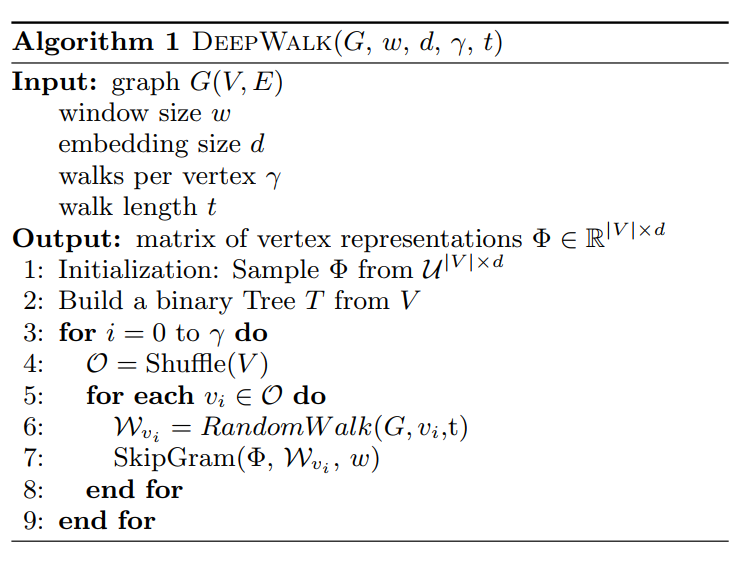

Might not use the line 2 which implements binary tree for hierarchical softmax instead we migh keep a normal structure and use negative sampling instead( contrastive loss)

In [21]:
def skip_gram_negative_sampling_loss(embeddings: nn.Embedding,
                                   context_embeddings: nn.Embedding,
                                   target: int,
                                   context,
                                   neg_samples: np.ndarray) -> torch.Tensor:
    """
    Calculates skip-gram loss with negative sampling
    
    Args:
        embeddings: Target embedding layer
        context_embeddings: Context embedding layer
        target: Target node index
        context: List of context node indices
        neg_samples: Array of negative sample indices
    
    Returns:
        Loss value as torch.Tensor
    """
    target_emb = embeddings(torch.tensor([target]))
    pos_loss = torch.tensor(0.0)
    neg_loss=torch.tensor(0.0)
    # Positive samples
    for ctx_node in context:
        ctx_emb = context_embeddings(torch.tensor([ctx_node]))
        score = torch.dot(target_emb.view(-1), ctx_emb.view(-1))
        pos_loss -= torch.log(torch.sigmoid(score)) #we want to minimize
    
    # Negative samples
    neg_embeddings = context_embeddings(torch.tensor(neg_samples))
    neg_scores = torch.matmul(target_emb, neg_embeddings.t())
    neg_loss -= torch.sum(torch.log(torch.sigmoid(-neg_scores).clamp(min=1e-12)))

    loss=neg_loss+pos_loss
    
    return loss

In [22]:
#deep walk 
def deep_walk(adj_matrix, T, gamma, length, d,  num_epochs=100,
             num_negative=5,learning_rate=0.01,aff_epoch=10):
    """_summary_

    Args:
        adj_matrix (array): adjacency matrix
        T (int): window size
        gamma (int): number of times we do a random walk from each vertex
        length (int): length of our random walk
        d (int): dimension of our latent space
        learning_rate (float): learning rate for updating embeddings
    """
    #init
    num_nodes = adj_matrix.shape[0]
    # # Initialize Φ with random values from uniform distribution
    # Phi = np.random.uniform(low=-1, high=1, size=(num_vertices, d))
    walks=[]
    
    #for loop on each vertex gamma
    for _ in range(gamma):
        #shuffle our adjacency matrix
        my_list = list(range(len(adj_matrix)))
        # O = rd.sample(my_list, len(my_list))
        D=np.sum(adj_matrix, axis=0)
        proba=D/np.sum(D)
        v=np.random.choice(my_list, p=proba) # first vertex choosen with P(w)

        walk = random_walk(adj_matrix, v, length)[1]
        walks.append(walk)

    #compute frequencies of our node in our random walk
    node_frequencies = np.zeros(num_nodes)
    for walk in walks:
        for node in walk:
            node_frequencies[node] += 1
    node_frequencies = node_frequencies ** 0.75  # Raised to 3/4 as in word2vec
    node_frequencies = node_frequencies / node_frequencies.sum()
    
    # Initialize embeddings
    embeddings = nn.Embedding(num_nodes, d)
    context_embeddings = nn.Embedding(num_nodes, d)
    optimizer = optim.SGD(list(embeddings.parameters()) + 
                         list(context_embeddings.parameters()), 
                         lr=learning_rate)
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        np.random.shuffle(walks)
        
        for walk in walks:
            for i, target in enumerate(walk):
                # Generate context pairs within window
                start = max(0, i - T)
                end = min(len(walk), i + T + 1)
                context = walk[start:i] + walk[i+1:end]
                
                # Sample negative examples
                neg_samples = np.random.choice(
                    num_nodes,
                    size=len(context) * num_negative,
                    p=node_frequencies
                )
                
                # Calculate loss with negative sampling
                loss = skip_gram_negative_sampling_loss(
                    embeddings,
                    context_embeddings,
                    target,
                    context,
                    neg_samples
                )
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
        
        if (epoch + 1) % aff_epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(walks):.4f}")
    
    return embeddings.weight.data

       
    
        

        
        
    

In [23]:
# Using PyTorch Geometric (recommended)
from torch_geometric.datasets import Planetoid

# # Load Cora
cora = Planetoid(root='/tmp/Cora', name='Cora')
# Access the data
data = cora[0]  

In [24]:
# Get adjacency matrix
from torch_geometric.utils import to_dense_adj


adj_matrix = to_dense_adj(data.edge_index)[0]
adj_matrix = adj_matrix.numpy()  # Convert to numpy for your random walk function

#  parameters from the paper
T = 5           # window size
gamma = 10      # number of walks
length = 40     # walk length
d = 128         # embedding dimension

# Run DeepWalk
embeddings = deep_walk(
    adj_matrix=adj_matrix, 
    T=T, 
    gamma=gamma, 
    length=length, 
    d=d,
    num_epochs=10,
    num_negative=5,
    learning_rate=0.025,
    aff_epoch=2
)

Epoch 2/10, Loss: 8233.6640
Epoch 4/10, Loss: 2654.6255
Epoch 6/10, Loss: 1298.1163
Epoch 8/10, Loss: 931.9586
Epoch 10/10, Loss: 797.9642


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier

# Get labels from your PyTorch Geometric data
labels = data.y.numpy()

# Convert embeddings to numpy if they're not already
X = embeddings.numpy() if isinstance(embeddings, torch.Tensor) else embeddings

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42
)

# Train a classifier
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate scores
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Micro-F1: {micro_f1:.4f}")
print(f"Macro-F1: {macro_f1:.4f}")

Accuracy: 0.2380
Micro-F1: 0.2380
Macro-F1: 0.1363
